In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
path = "F:/for learn/Python_MachineLearning/"
df = pd.read_csv(path + "housing.data", 
                 header=None, 
                 sep="\s+")
df.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


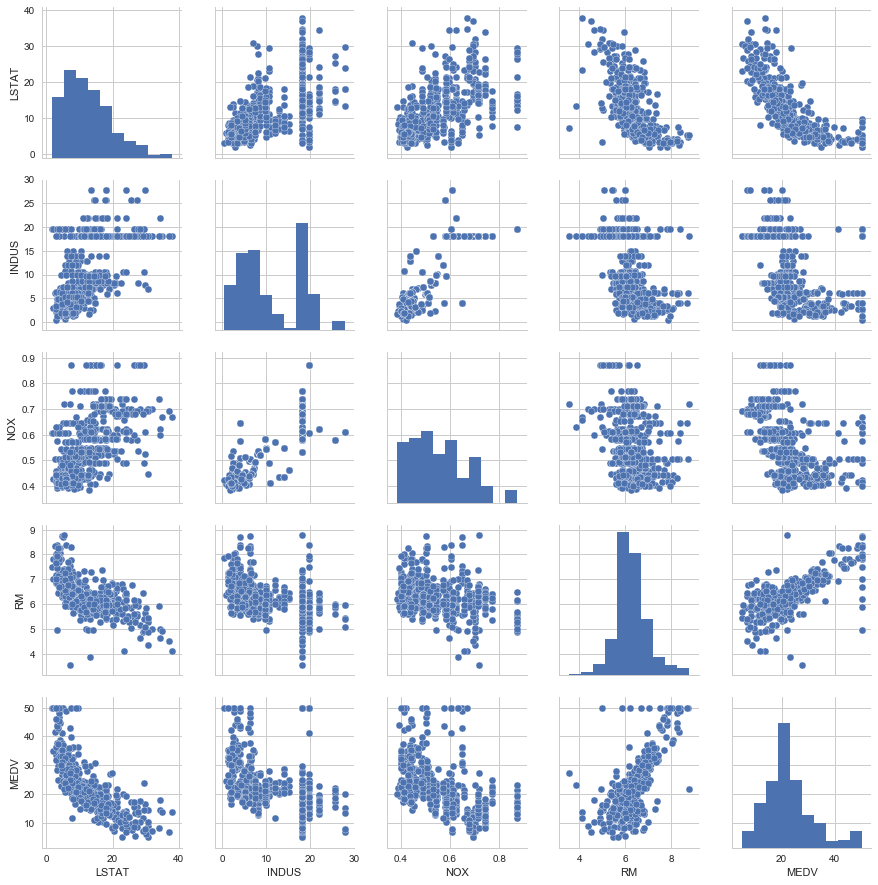

In [115]:
# 绘制多变量图
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.show()

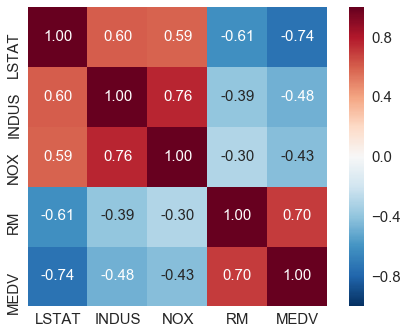

In [122]:
# 生成选定特征的相关系数矩阵
# 等同于 np.corrcoef(df[cols].values.T)
cm = np.corrcoef(df[cols].values, rowvar=False)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 15}, 
                 yticklabels=cols, 
                 xticklabels=cols)
plt.show()

In [118]:
# 建立梯度下降回归类
class LinearRegressionGD():
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
    def __fix_input(self, X):
        X = np.mat(X)
        X0 = np.mat(np.ones(X.shape[0])).T
        return np.hstack((X0, X))
    def fit(self, X, y):
        self.y = np.mat(y).reshape(-1, 1)
        self.X = self.__fix_input(X)
        self.w_ = np.mat(np.zeros(self.X.shape[1])).T
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.X * self.w_
            errors = self.y - output
            self.w_ += self.eta * self.X.T * errors
            cost = np.square(errors).sum() / 2.0
            self.cost_.append(cost)
        return self
    def predict(self, X):
        fixed_X = self.__fix_input(X)
        return fixed_X * self.w_

In [119]:
X = df[["RM"]].values
y = df[["MEDV"]].values
from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
yscaler = StandardScaler()
x_std = xscaler.fit_transform(X)
y_std = yscaler.fit_transform(y)
lr = LinearRegressionGD()
lr.fit(x_std, y_std)

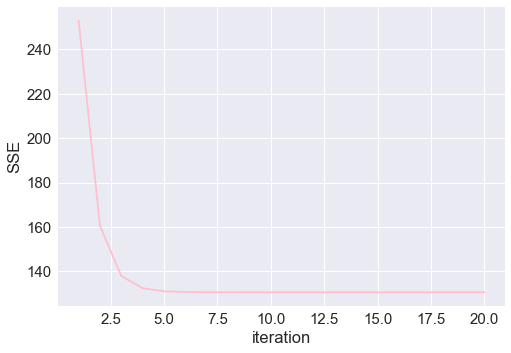

In [123]:
# 导入了sns库后，会覆盖plt的默认图像显示方式，此命令可以重设风格
# sns.reset_orig()
plt.plot(range(1, lr.n_iter+1), lr.cost_, color='pink')
plt.xlabel('iteration')
plt.ylabel('SSE')
plt.show()

In [132]:
def lin_regplot(X, y, model, xlabel=None, ylabel=None):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

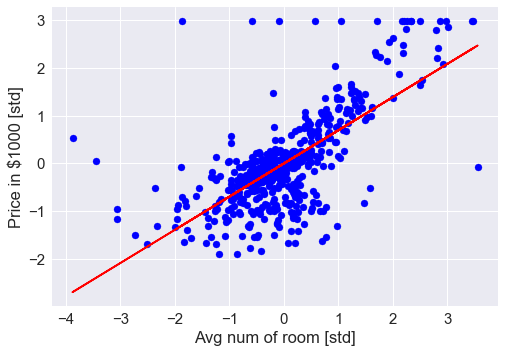

In [124]:
lin_regplot(x_std, y_std, lr, xlabel="Avg num of room [std]", ylabel="Price in $1000 [std]")

In [127]:
print("the slope of lr is %.3f" % lr.w_[1])
print("the intercept of lr is %.3f" % lr.w_[0])

the slope of lr is 0.695
the intercept of lr is -0.000


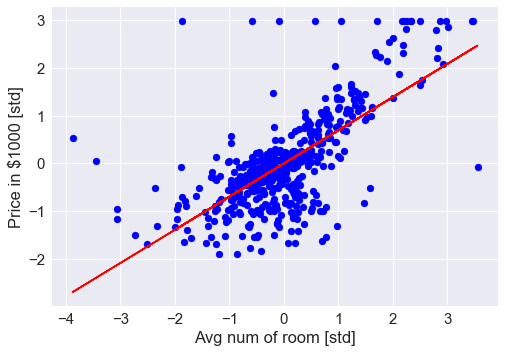

In [128]:
# 用 sklearn进行回归分析
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(x_std, y_std)
lin_regplot(x_std, y_std, slr, xlabel="Avg num of room [std]", ylabel="Price in $1000 [std]")

In [131]:
print("the slope of slr is %.3f" % slr.coef_[0])
print("the intercept of slr is %.3f" % slr.intercept_[0])

the slope of slr is 0.695
the intercept of slr is -0.000


In [138]:
# 用 RANSAC方法进行高鲁棒性回归
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(base_estimator=LinearRegression(),
                         max_trials=100, 
                         min_samples=50, 
                         loss="absolute_loss", 
                         residual_threshold=5.0, 
                         random_state=0 )
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [149]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_x = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_x.reshape(-1, 1))

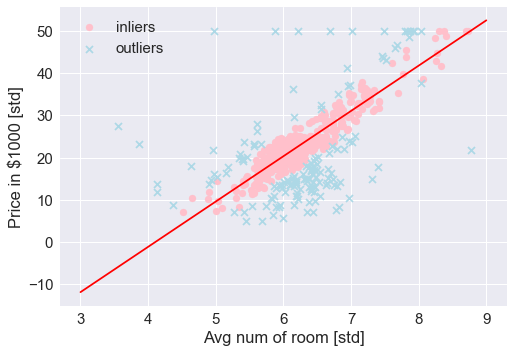

In [152]:
plt.scatter(X[inlier_mask], y[inlier_mask], c='pink', marker='o', label='inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightblue', marker='x', label='outliers')
plt.plot(line_x, line_y_ransac, color='red')
plt.xlabel("Avg num of room [std]")
plt.ylabel("Price in $1000 [std]")
plt.legend(loc="upper left")
plt.show()

In [153]:
print("the slope of ransac is: %.3f" % ransac.estimator_.coef_[0])
print("the intercept of ransac is: %.3f" % ransac.estimator_.intercept_[0])

the slope of ransac is: 10.735
the intercept of ransac is: -44.089
